## Import libraries

In [62]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras import layers

### import dataset from directory

In [63]:
# devide train data into train and validation data set, 80% train, 20% validation data set

train_data=tf.keras.utils.image_dataset_from_directory(
    "C:\\Users\\AMAN DHANOTIYA\\Desktop\\TSF\\10_food_classes_all_data\\train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    color_mode='rgb',
)

validation=tf.keras.utils.image_dataset_from_directory(
    "C:\\Users\\AMAN DHANOTIYA\\Desktop\\TSF\\10_food_classes_all_data\\train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    shuffle=False,
    seed=42,
    validation_split=0.2,
    subset='validation',
    color_mode='rgb',
)

Found 7500 files belonging to 10 classes.
Using 6000 files for training.
Found 7500 files belonging to 10 classes.
Using 1500 files for validation.


In [64]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Input image data is of shape 256X256X3, here 3 for RGB channels and 256X256 are pixels,and  selected batch size is 16 so in one iteration 16 images are trained  

In [65]:
# Classes name in the dataset
a = train_data.class_names
print(a)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


###  Showing the image of dataset with labels

(32, 256, 256, 3)


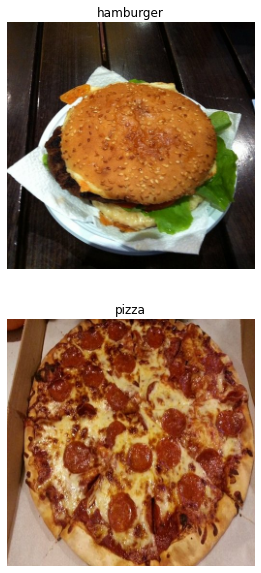

In [66]:
# the shape print below is shape of batch size 32 and shape of image is 256*256*3

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    print(images.shape)
    for i in range(2):
        ax = plt.subplot(2, 1, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         print(labels[i])
        plt.title(a[labels[i]])
        plt.axis("off")

In [67]:
# Shape of image in batch size 

for i, j in train_data:
    print(i[0].shape)
    print(j[0])
    break


(256, 256, 3)
tf.Tensor(6, shape=(), dtype=int32)


hamburger


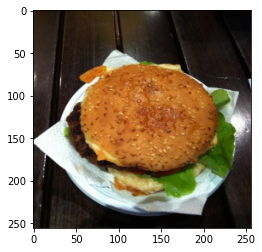

In [68]:
plt.imshow(images[0].numpy().astype("uint8"))
print(a[labels[0]])

### Data preprocessing :- Normalize the image numpy array between 0 to 1,
### Data augmentation:- flipping, rotation, zoom, crop.


#### For preprocessing, first, I normalize the numpy array of images and convert its value between 0 and 1. This applies to all datasets. It helps decrease computation and increase the learning process.
#### I also decreased the image size to 128X128X3. Due to this, computations are fast, and fewer parameters are required to train the model. When I try with size 224X224X3, the time required for executing this task is more that's why I reduced its size.



In [69]:
norm = tf.keras.layers.Rescaling(1./255)

In [70]:
train_data=train_data.map(lambda x, y: (norm(x), y))

In [82]:
validation=validation.map(lambda x, y: (norm(x), y))

#### For data augmentation, I use random flip- which flip the image horizontally (left-right flip), vertically (top-bottom flip). Then I use some image rotation to rotate the image by some degree and zoom the image with some factors.
#### I tried to change the brightness, but after using it, the image changed into black, so I commented out it.
#### Data augmentation tries to reduce the overfitting of the model and get better results.


In [83]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3,0.2),
#     layers.RandomBrightness(0.7),
])

### Example image after data augmentation 

In [92]:
eg = data_augmentation(images)

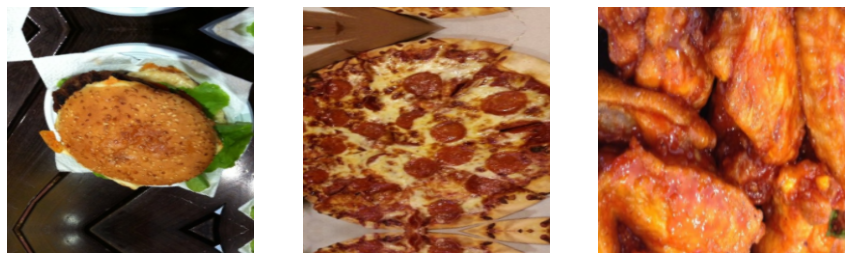

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
for i in range(3):
    # convert to unsigned integers
    image = eg[i]
 
    # plot image
    ax[i].imshow(image/255)
    ax[i].axis('off')

In [94]:
tf.get_logger().setLevel('ERROR')
train_data=train_data.map(lambda x, y: (data_augmentation(x), y))

chicken_wings


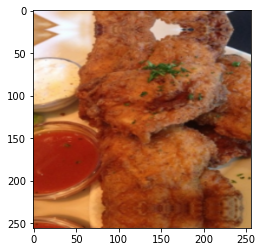

In [95]:
x,y=next(iter(train_data))
plt.imshow(x[0])
print(a[y[0]])

### Importing VGG16 model, In which convolution base is taken as trained and flatten and dense layer is taken as trainable parameter


In [14]:
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16

In [15]:
SIZE = [128,128]

In [16]:
vgg = VGG16(input_shape = SIZE + [3], weights = 'imagenet', include_top = False)

### Take 3 dense layer and 1 output laer with 10 classes


In [17]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(512, activation = 'relu')(x)   
x = Dense(256, activation = 'relu')(x) 

x = Dense(10, activation = 'softmax')(x)

In [18]:
model = Model(inputs = vgg.input, outputs = x)
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

### Convert train and validation data into required format of VGG model


In [20]:
from keras.applications.vgg16 import preprocess_input

In [21]:
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (128,128))
    return (image, label)

In [22]:
train_data=train_data.map(preprocess_dataset)

In [23]:
validation= validation.map(preprocess_dataset)

In [24]:
x,y=next(iter(validation))

steak


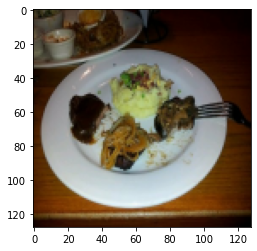

In [25]:
plt.imshow(x[0])
print(a[y[0]])

### Fit the model 

In [26]:
fitting=model.fit(
  train_data,
  validation_data=validation,
  epochs=10,
)

Epoch 1/10
188/188 [==============================] - 274s 1s/step - loss: 2.1473 - accuracy: 0.2478 - val_loss: 1.9973 - val_accuracy: 0.3240
Epoch 2/10
188/188 [==============================] - 275s 1s/step - loss: 1.8032 - accuracy: 0.4253 - val_loss: 1.7524 - val_accuracy: 0.4300
Epoch 3/10
188/188 [==============================] - 316s 2s/step - loss: 1.5810 - accuracy: 0.5035 - val_loss: 1.5795 - val_accuracy: 0.4880
Epoch 4/10
188/188 [==============================] - 292s 2s/step - loss: 1.4257 - accuracy: 0.5572 - val_loss: 1.4207 - val_accuracy: 0.5580
Epoch 5/10
188/188 [==============================] - 290s 2s/step - loss: 1.3121 - accuracy: 0.5958 - val_loss: 1.3590 - val_accuracy: 0.5753
Epoch 6/10
188/188 [==============================] - 277s 1s/step - loss: 1.2251 - accuracy: 0.6255 - val_loss: 1.2377 - val_accuracy: 0.6300
Epoch 7/10
188/188 [==============================] - 9588s 51s/step - loss: 1.1486 - accuracy: 0.6522 - val_loss: 1.2348 - val_accuracy: 0.62

### Showing graph between loss and accuracy with epoch 

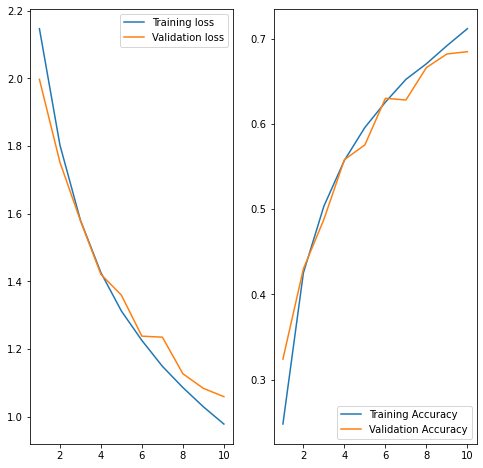

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

loss=fitting.history['loss']
loss_val=fitting.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,loss_val,label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
acc=fitting.history['accuracy']
acc_val=fitting.history['val_accuracy']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,acc_val,label='Validation Accuracy')
plt.legend(loc='lower right')

### Import test data set and normalise it and reshape  

In [28]:
test_data=tf.keras.utils.image_dataset_from_directory(
    "C:\\Users\\AMAN DHANOTIYA\\Desktop\\TSF\\10_food_classes_all_data\\test",
    labels='inferred',
    label_mode='int',
    batch_size=1,
    shuffle=False,
    color_mode='rgb',
)
# clas = test_data.labels
# xx=test_data.classes
test_data=test_data.map(lambda x, y: (norm(x), y))
test_data=test_data.map(preprocess_dataset)

Found 2500 files belonging to 10 classes.


### Here r is storing the correct label of test data set 

In [29]:
r=[]
for images, labels in test_data:
#     print(images.shape)
    for i in range(len(labels)):
        r.append(labels[i].numpy())
        

In [30]:
r

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [31]:
x,y=next(iter(test_data))
y[0]

<tf.Tensor: shape=(), dtype=int32, numpy=0>

chicken_curry


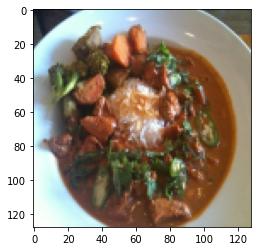

In [32]:
plt.imshow(x[0])
print(a[y[0]])

### prediction 

In [33]:
pred=model.predict(test_data)

2500/2500 [==============================] - 148s 59ms/step


In [34]:
labels = np.argmax(pred, axis=-1)

### labels storing the predicted class of testdata set

In [35]:
labels.size

2500

## Matrics used in this model is accuracy matrics which show the precession, recall, f1-score, accuracy of all the classes present in the dataset

### Precession, Recall and f1 score

In [36]:
import sklearn.metrics 
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
report = metrics.classification_report(r, labels)
print(report)    

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       250
           1       0.52      0.60      0.55       250
           2       0.67      0.72      0.69       250
           3       0.57      0.44      0.49       250
           4       0.61      0.64      0.62       250
           5       0.68      0.71      0.69       250
           6       0.77      0.74      0.75       250
           7       0.74      0.64      0.69       250
           8       0.49      0.51      0.50       250
           9       0.66      0.67      0.66       250

    accuracy                           0.62      2500
   macro avg       0.62      0.62      0.62      2500
weighted avg       0.62      0.62      0.62      2500



### Confusion Matrix

In [37]:
c_m = confusion_matrix(labels, r)
c_m

array([[140,  12,  15,   8,   7,  12,  13,  39,   7,   6],
       [ 16, 149,   4,  30,  20,   9,   4,   4,  40,  11],
       [ 23,   1, 181,   6,   4,   4,  24,  20,   3,   5],
       [  7,  11,   8, 109,  11,   1,   2,   2,  26,  14],
       [  7,  18,   3,  21, 159,  15,   4,   7,  18,   9],
       [  8,  11,  11,   5,  18, 177,   3,   8,   8,  13],
       [ 10,   7,  12,   8,   2,   1, 184,   4,   5,   5],
       [ 20,   2,   8,   4,   3,   7,   4, 161,   5,   4],
       [ 13,  24,   5,  38,  17,  11,   4,   3, 127,  15],
       [  6,  15,   3,  21,   9,  13,   8,   2,  11, 168]], dtype=int64)

#### First model i try with fewer number of layers.

In [96]:
model4 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32,(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
    
])


In [97]:
model4.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

####  In this model, if I assign stride=1 and padding is the same then accuracy is increased and with fewer layers.

In [98]:
fitting4=model4.fit(
  train_data,
  validation_data=validation,
  epochs=3,
)

Epoch 1/3
188/188 [==============================] - 809s 4s/step - loss: 2.5146 - accuracy: 0.1118 - val_loss: 2.2376 - val_accuracy: 0.0353
Epoch 2/3
188/188 [==============================] - 822s 4s/step - loss: 2.2371 - accuracy: 0.1643 - val_loss: 2.3107 - val_accuracy: 0.1067
Epoch 3/3
188/188 [==============================] - 853s 5s/step - loss: 2.1604 - accuracy: 0.2135 - val_loss: 2.1403 - val_accuracy: 0.2527


#### 2nd model i tried with similar layers of VGG16 model

In [38]:
# model2 = tf.keras.Sequential([
    
#   tf.keras.layers.Conv2D(64,(3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(64, (3, 3), strides=1,padding='same',activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(128, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(128, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(256, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(256, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(256, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(512, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(512, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(512, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(512, (3, 3), strides=1,padding='same',activation='relu'),
#   tf.keras.layers.Conv2D(512, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.Conv2D(512, (3, 3),strides=1,padding='same', activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10,activation='softmax')
    
# ])

In [39]:
# model2.compile(
#   optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#   metrics=['accuracy'])

In [47]:
# fitting=model2.fit(
#   train_data,
#   validation_data=validation,
#   epochs=10,
# )

#### It took so much time to execute thats why i comment this.

#### Resnet 50 

In [41]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [42]:
train_data=train_data.map(preprocess_dataset)
validation=validation.map(preprocess_dataset)

In [43]:
resnet = ResNet50(weights='imagenet',
                      input_shape= (128,128,3),
                      include_top= False)  


#show the base model summary 
resnet.summary()
#show how manay layers in the Resnet Network
layers = resnet.layers

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [44]:
for layer in resnet.layers:
    layer.trainable = False
    
x = Flatten()(resnet.output)
x = Dense(512, activation = 'relu')(x)   
x = Dense(256, activation = 'relu')(x) 
# x = Dense(128, activation = 'relu')(x)  

x = Dense(10, activation = 'softmax')(x)

In [45]:
model3 = Model(inputs = resnet.input, outputs = x)
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.0001)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=optm, metrics=['accuracy'])

In [46]:
fitting=model3.fit(
  train_data,
  validation_data=validation,
  epochs=10,
)

Epoch 1/10
188/188 [==============================] - 217s 1s/step - loss: 2.2982 - accuracy: 0.1315 - val_loss: 2.1695 - val_accuracy: 0.2387
Epoch 2/10
188/188 [==============================] - 210s 1s/step - loss: 2.2281 - accuracy: 0.1707 - val_loss: 1.8803 - val_accuracy: 0.4960
Epoch 3/10
188/188 [==============================] - 205s 1s/step - loss: 2.1902 - accuracy: 0.1907 - val_loss: 2.2389 - val_accuracy: 0.1233
Epoch 4/10
188/188 [==============================] - 208s 1s/step - loss: 2.1444 - accuracy: 0.2257 - val_loss: 1.8754 - val_accuracy: 0.2973
Epoch 5/10
188/188 [==============================] - 213s 1s/step - loss: 2.1084 - accuracy: 0.2422 - val_loss: 1.9479 - val_accuracy: 0.3273
Epoch 6/10
188/188 [==============================] - 214s 1s/step - loss: 2.0593 - accuracy: 0.2613 - val_loss: 1.9965 - val_accuracy: 0.2893
Epoch 7/10
188/188 [==============================] - 199s 1s/step - loss: 2.0300 - accuracy: 0.2773 - val_loss: 1.8168 - val_accuracy: 0.3880

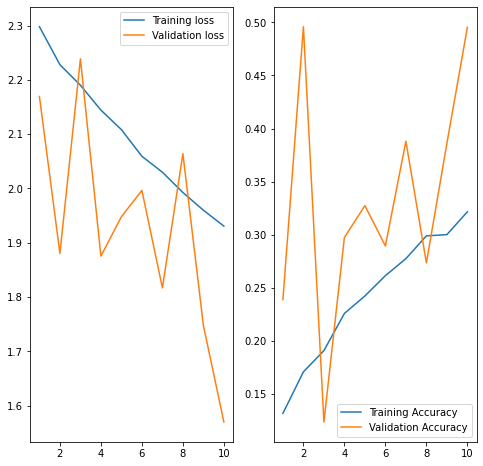

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

loss=fitting.history['loss']
loss_val=fitting.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,loss_val,label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
acc=fitting.history['accuracy']
acc_val=fitting.history['val_accuracy']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,acc_val,label='Validation Accuracy')
plt.legend(loc='lower right')

In [ ]:
# The validation accuracy are more fluctuating in this case.

## Convolutional Operations 

#### Convolutional operations are the core of the CNN model. In CNN, Convolutional operations are performed to extract image features and details and edge detection. This is done with the help of filters. We use many layers for feature extractions, and in every layer, so many filters are present, they perform the feature extraction task from the image matrix.
#### We can use different filter sizes like 3X3,5X5,7X7, which roll or hover on the input matrix and give the output matrix for layer 2. If the input image is like nXnX3 shape and size of the filter and the number of filters is 3*3, m respectively, then the output is of (n-3+1)X(n-3+1)Xm.
#### When we perform this task, the size of our original matrix decreases, so to prevent losing the information or essential features, we provide padding for our input image so we get a similar dimension matrix for the next layer. 
#### The term stride is also used in this layer. Stride means how many jumps or steps we take when hovering the filter or pooling matrix on the input matrix.
#### In convolution operation, we also use a pooling layer, which reduces the number of parameters and computations in the network. It also uses for overfitting. Ex- Max pooling layer, average pooling layer, etc. We have defined the size of the matrix for performing this task. If we assign a size 2X2, we get the output matrix as n/2Xn/2 size. 
#### Last is the flattened layer. In this layer, all the values or parameters are converted into a 1-dimensional matrix and then passed to the solver or activation function. And then using, the backpropagation model is trained, and values of the filter matrix and pooling matrix are tuned.




#### First, I used this type of architecture in which I tried with 3 convolutional layers, 1 max pooling layer, 1 flatten layer, and 3 dense layers. With this model, I do not get significant accuracy, so I go for next model.
#### Next, I tried the architecture similar to the VGG16 model, but the time required for executing this was very high due to more parameters and many filters.
#### Then I tried the Vgg16 model, and my accuracy increased from the previous. From vgg16, I select the same convolutional base as already trained on the imagenet dataset,try this model with different parameters like batch size number of dense layer, parameters in dense layer and dropout layer, etc. 
#### When I use the dropout layer, the results are not so good compared to using without it. The one reason behind this is that in dropping, some important features may drop.
#### After removing the dropout layer, my validation accuracy is so much fluctuates. Then I searched for it. Then finally, the results were more satisfactory by reducing the learning rate. The default learning rate is 0.001. I try for 0.00001 and get less fluctuating accuracy than the previous model.
#### I also tried Resnet50, but the best accuracy got in VGG16.
